In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt  
from matplotlib.animation import FuncAnimation, PillowWriter  
import random

# Define Dataset

Reference

An example came from "The fundamental financial management of business"


In [3]:
# Original dataset

data = [[40,20,8.3,1.65],[80,40,10,2.0],[120,60,15,2.7]]
df = pd.DataFrame(data=data,columns=['Debt(million)','Debt Ratio(%)','Interest(%)','Risk constant'])
df

,Debt(million),Debt Ratio(%),Interest(%),Risk constant
0,40,20,8.3,1.65
1,80,40,10.0,2.00
2,120,60,15.0,2.70


In [4]:
# Additional Information

Expected_Sales = 200 # million bahts
FixCost = 40 # million bahts
VariableCost = 0.6*Expected_Sales  # 60% of sales
Taxes = 0.3 # 30% Percent of net profit
num_shares_NoDebt = 10 # million shares
riskfree_return = 0.06 # Percentage
market_risk = 0.1 # Percentage

### Make quadratic interpolations 

In [5]:
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

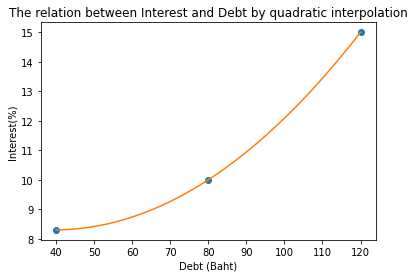

In [64]:
# f_interest stands for function of interest
xnew = np.linspace(40, 120)
f_interest = interp1d(df['Debt(million)'], df['Interest(%)'], kind='quadratic')
plt.title("The relation between Interest and Debt by quadratic interpolation")
plt.xlabel("Debt (Baht)")
plt.ylabel("Interest(%)")
plt.plot(df['Debt(million)'], df['Interest(%)'], 'o', xnew, f_interest(xnew), '-') 
plt.savefig("Interest_Plot.jpg",dpi=300)

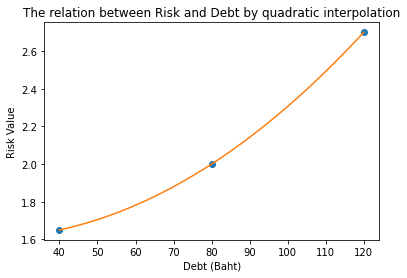

In [65]:
# f_risk stands for function of risk
xnew = np.linspace(40, 120)
f_risk = interp1d(df['Debt(million)'], df['Risk constant'], kind='quadratic')
plt.title("The relation between Risk and Debt by quadratic interpolation")
plt.xlabel("Debt (Baht)")
plt.ylabel("Risk Value")
plt.plot(df['Debt(million)'], df['Risk constant'], 'o', xnew, f_risk(xnew), '-') 
plt.savefig("Risk_Plot.jpg",dpi=300)

### Define indicators

In [8]:
# Earning per shares

def EPS(interest,debt):
    num_shares = 10*(1-debt/Expected_Sales)
    earning = Expected_Sales - VariableCost - FixCost - (interest*0.01*debt)
    after_taxes = 1- Taxes
    eps = earning*after_taxes/num_shares
    
    return eps

def return_to_sharesholder(risk):
    ks = riskfree_return + (market_risk-riskfree_return)*risk
    
    return ks

# Gordon Growth Model under the assumption that a company provides 100% of earning as dividend which means dividend growth is zero.

def Price(dividend,ks):
    p = dividend/ks
    
    return p

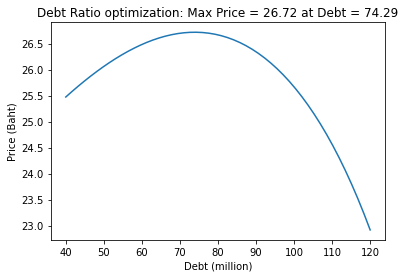

In [59]:
#Test 

debt = np.linspace(40, 120)
interest = f_interest(debt)
risk = f_risk(debt)
Price_plot = Price(EPS(interest,debt),return_to_sharesholder(risk))

f_Interest = interp1d(df['Debt(million)'], df['Interest(%)'], kind='quadratic')
plt.title("Debt Ratio optimization: Max Price = " + str(np.round(np.max(Price_plot),2)) + " at Debt = "+ str(np.round(debt[np.argmax(Price_plot)],2)) )
plt.xlabel("Debt (million)")
plt.ylabel("Price (Baht)")
plt.plot(debt, Price_plot, '-') 
plt.savefig("Problem Plot.jpg",dpi=300)


### Gif save

In [10]:
def GifPlot(history,debt,P0,epochs,name="HC",step=0.1,nn_size = 1):
    fig, ax = plt.subplots()  
    x0 = np.linspace(40, 120)
    bg = plt.plot(x0, Price_plot, 'k-')
    max_val = plt.plot(debt, P0, 'co')
    ln1, = plt.plot([], [], 'ro')  
                    
    def init():
        ax.set_xlim(30, 130)  
        ax.set_ylim(22, 28)  

    def update(i):  
        x = i
        y = Price(EPS(f_interest(i),i),return_to_sharesholder(f_risk(i)))
        plt.plot(debt, P0, 'co')
        ln1.set_data(x, y) 
                        
                     
    ani = FuncAnimation(fig, update, history, init_func=init)  
    plt.title("First-Choice HC \n Solution: Max Price = {:.2f} at Debt ={:.2f} in {} epochs".format(P0,debt,epochs))
    plt.show()
    writer = PillowWriter(fps=12)  
    ani.save(name+"_step"+str(step)+".gif", writer=writer,dpi=150)

### Neighbor Size

In [11]:
def Neighbors(x0,step,size):
    neighbors = [ x0 + i*step for i in np.arange(-size,size+1) if i != 0]
    return np.array(neighbors)

# Max Optimization 

### Hill Climbing Algorithm

In [12]:
# Steepest-Ascent
def HC_steepest(debt0,step=0.01,mode='random', step_plot=False,num_n=1):
    debt = debt0
    risk = f_risk(debt0)
    interest = f_interest(debt0)
    history = []
    P0 = Price(EPS(interest,debt),return_to_sharesholder(risk))
    epochs = 1
    if mode == 'random':
        
        while epochs < 2000:
            
            if step_plot:
                history.append(debt)
                
            neighbors=Neighbors(debt,step,num_n)
            neighbors_price  = Price(EPS(f_interest(neighbors),neighbors),return_to_sharesholder(f_risk(neighbors)))
            highest_n = np.argmax(neighbors_price)
            
            #print(neighbors_price[highest_n])
            if neighbors_price[highest_n] > P0:
                
                debt = neighbors[highest_n]
                P0 = neighbors_price[highest_n]
                #print(neighbors,neighbors[highest_n],P0)
                epochs += 1
                
            else:
                if step_plot :
                    GifPlot(history,debt=debt,P0=P0,epochs=epochs,name="HC_steepest",step=step)
                    
                return [epochs,debt,P0,debt0]
        return[epochs,debt,P0,debt0]
            
            

In [13]:
# Stochastic
def HC_stochastic(debt0,step=0.1,mode='random', step_plot=False,num_n=1):
    debt = debt0
    risk = f_risk(debt0)
    interest = f_interest(debt0)
    history = []
    P0 = Price(EPS(interest,debt),return_to_sharesholder(risk))
    epochs = 1
    if mode == 'random':
        
        while epochs < 2000:
            if step_plot:
                history.append(debt)
            
            neighbors=Neighbors(debt,step,num_n)
            neighbors_price = Price(EPS(f_interest(neighbors),neighbors),return_to_sharesholder(f_risk(neighbors)))

            neighbors = neighbors[neighbors_price>P0]
            neighbors_price  = neighbors_price[neighbors_price>P0]
            index = np.arange(len(neighbors))
            np.random.shuffle(index)

            if neighbors.any():
                #print(neighbors,neighbors[index[0]])
                debt = neighbors[index[0]]
                P0 = neighbors_price[index[0]]
                epochs += 1
            else:
                if step_plot :
                    GifPlot(history,debt=debt,P0=P0,epochs=epochs,name="HC_stochastic",step=step)
                    print('---------------------------------')
                return [epochs,debt,P0,debt0]
        return[epochs,debt,P0,debt0]
        

In [36]:
# First Choice
def HC_FC(debt0,step=0.1,mode='random', step_plot=False,num_n=1):
    debt = debt0
    risk = f_risk(debt0)
    interest = f_interest(debt0)
    history = []
    P0 = Price(EPS(interest,debt),return_to_sharesholder(risk))
    epochs = 1
    if mode == 'random':
        
        while epochs < 2000:
            if step_plot:
                history.append(debt)
            neighbors=Neighbors(debt,step,num_n)
            neighbors_price = Price(EPS(f_interest(neighbors),neighbors),return_to_sharesholder(f_risk(neighbors)))
            
            if np.any(neighbors_price > P0):
                # pick the first higher
                debt = neighbors[neighbors_price > P0][0]
                P0 = neighbors_price[neighbors_price > P0][0]
                epochs += 1
                #print(debt)
            else:
                if step_plot :
                    GifPlot(history,debt=debt,P0=P0,epochs=epochs,name="HC_FC",step=step)
                return [epochs,debt,P0,debt0]
        return[epochs,debt,P0,debt0]

## Experiments

## --------Experiment 1: Random-Restart initialization with various step size--------

In [29]:
random_init = [random.random()*79+40 for i in range(50)]

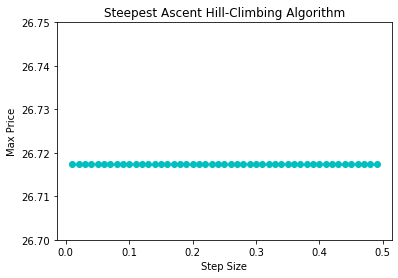

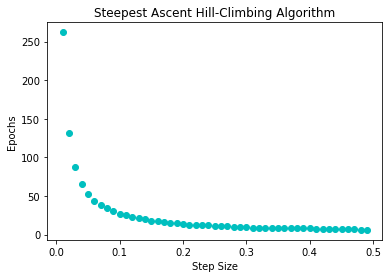

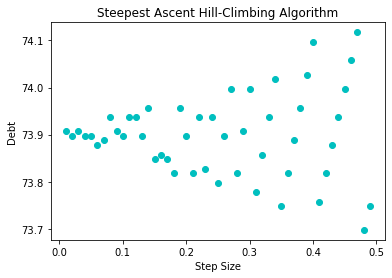

In [50]:
ep_plot =[]
price_plot =[]


for step in np.arange(0.01,0.5,0.01):
    for init_val in random_init:
        #print(init_val)
        max_price,max_debt,ep = 0,0,0
        # Choose Method
        ep,debt,price,_ = HC_steepest(init_val,step=step,num_n=1)
        #_,__,price,___ = HC_stochastic(init_val,step=0.1)
        #_,__,price,___ = HC_FC(init_val,step=0.1)

        if price > max_price:
            max_price = price
            max_ep = ep
    #print("step=" + str(step)+" Complete")
    ep_plot.append(max_ep)
    price_plot.append(max_price)

plt.title("Steepest Ascent Hill-Climbing Algorithm")
plt.xlabel("Step Size")
plt.ylabel("Max Price")
plt.ylim(26.70,26.75)
plt.plot(np.arange(0.01,0.5,0.01),price_plot,'co')
plt.savefig("SAHC_price.jpg" ,dpi = 300)
plt.show()

plt.title("Steepest Ascent Hill-Climbing Algorithm")
plt.xlabel("Step Size")
plt.ylabel("Epochs")
plt.plot(np.arange(0.01,0.5,0.01),ep_plot,'co')
plt.savefig("SAHC_epochs.jpg" ,dpi = 300)
plt.show()



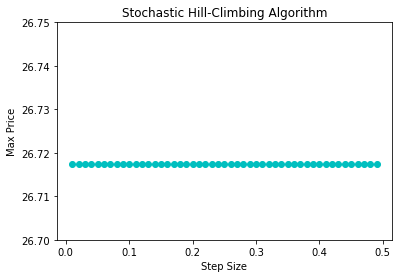

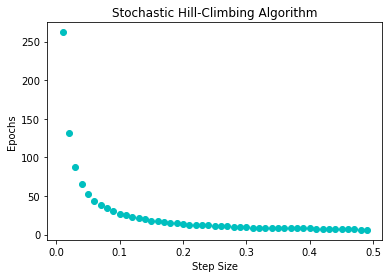

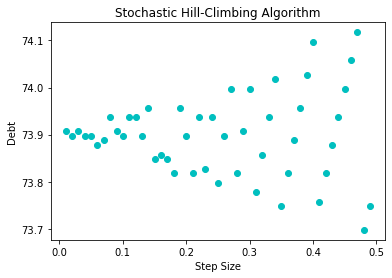

In [51]:
ep_plot =[]
price_plot =[]

for step in np.arange(0.01,0.5,0.01):
    for init_val in random_init:
        max_price = 0

        ep = None
        # Choose Method
        ep,debt,price,_ = HC_stochastic(init_val,step=step,num_n=1)
        #_,__,price,___ = HC_stochastic(init_val,step=0.1)
        #_,__,price,___ = HC_FC(init_val,step=0.1)

        if price > max_price:
            max_price = price
            max_ep = ep
    #print("step=" + str(step)+" Complete")
    debt_plot.append(max_debt)
    ep_plot.append(max_ep)
    price_plot.append(max_price)

plt.title("Stochastic Hill-Climbing Algorithm")   
plt.ylim(26.70,26.75)
plt.xlabel("Step Size")
plt.ylabel("Max Price")
plt.plot(np.arange(0.01,0.5,0.01),price_plot,'co')
plt.savefig("STHC_price.jpg" ,dpi = 300)
plt.show()

plt.title("Stochastic Hill-Climbing Algorithm")  
plt.xlabel("Step Size")
plt.ylabel("Epochs")
plt.plot(np.arange(0.01,0.5,0.01),ep_plot,'co')
plt.savefig("STHC_epochs.jpg" ,dpi = 300)
plt.show()



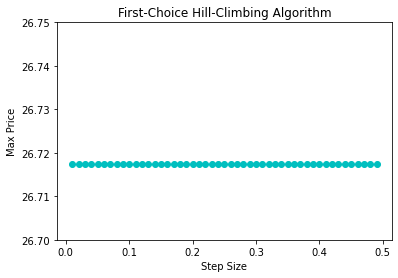

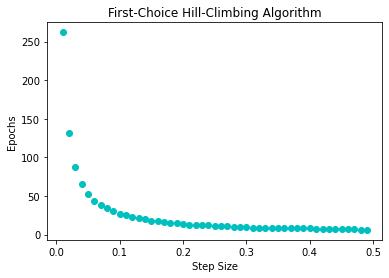

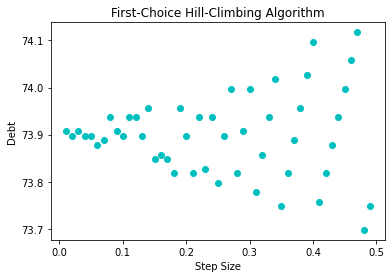

In [52]:
ep_plot =[]
price_plot =[]
for step in np.arange(0.01,0.5,0.01):
    for init_val in random_init:
        max_price = 0
        ep = None
        # Choose Method
        ep,debt,price,_ = HC_FC(init_val,step=step,num_n=1)

        
        if price > max_price:
            max_price = price
            max_ep = ep
    #print("step=" + str(step)+" Complete")
    debt_plot.append(max_debt)
    ep_plot.append(max_ep)
    price_plot.append(max_price)
    
plt.title("First-Choice Hill-Climbing Algorithm")  
plt.ylim(26.70,26.75)
plt.xlabel("Step Size")
plt.ylabel("Max Price")
plt.plot(np.arange(0.01,0.5,0.01),price_plot,'co')
plt.savefig("FCHC_price.jpg" ,dpi = 300)
plt.show()

plt.title("First-Choice Hill-Climbing Algorithm")  
plt.xlabel("Step Size")
plt.ylabel("Epochs")
plt.plot(np.arange(0.01,0.5,0.01),ep_plot,'co')
plt.savefig("FCHC_epochs.jpg" ,dpi = 300)
plt.show()



## --------Experiment 2: Random-Restart initialization step size = 0.1 nn = [1,10]--------

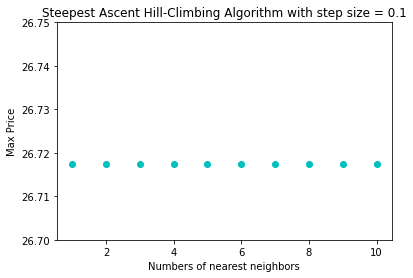

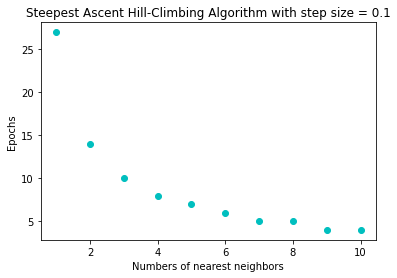

In [47]:
ep_plot =[]
price_plot =[]
for nn in np.arange(1,11,1):
    for init_val in random_init:
        max_price = 0
        ep = None
        # Choose Method
        ep,debt,price,_ = HC_steepest(init_val,step=0.1,num_n=nn)
        #_,__,price,___ = HC_stochastic(init_val,step=0.1)
        #_,__,price,___ = HC_FC(init_val,step=0.1)

        if price > max_price:
            max_price = price
            #max_debt = debt
            max_ep = ep
    #print("step=" + str(step)+" Complete")
    ep_plot.append(max_ep)
    price_plot.append(max_price)

plt.title("Steepest Ascent Hill-Climbing Algorithm with step size = 0.1")
plt.ylim(26.70,26.75)
plt.xlabel("Numbers of nearest neighbors")
plt.ylabel("Max Price")
plt.plot(np.arange(1,11,1),price_plot,'co')
plt.savefig("NN_SAHC_price.jpg",dpi=300)
plt.show()


plt.title("Steepest Ascent Hill-Climbing Algorithm with step size = 0.1")
plt.xlabel("Numbers of nearest neighbors")
plt.ylabel("Epochs")
plt.plot(np.arange(1,11,1),ep_plot,'co')
plt.savefig("NN_SAHC_epochs.jpg",dpi=300)
plt.show()

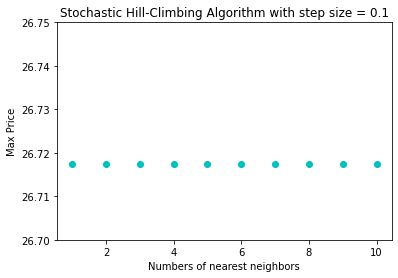

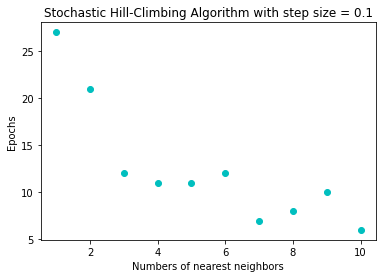

In [48]:
ep_plot =[]
price_plot =[]
for nn in np.arange(1,11,1):
    for init_val in random_init:
        max_price = 0
        ep = None
        # Choose Method
        ep,debt,price,_ = HC_stochastic(init_val,step=0.1,num_n=nn)
        #_,__,price,___ = HC_stochastic(init_val,step=0.1)
        #_,__,price,___ = HC_FC(init_val,step=0.1)

        if price > max_price:
            max_price = price
            #max_debt = debt
            max_ep = ep
    #print("step=" + str(step)+" Complete")
    ep_plot.append(max_ep)
    price_plot.append(max_price)
    
plt.title("Stochastic Hill-Climbing Algorithm with step size = 0.1")
plt.ylim(26.70,26.75)
plt.xlabel("Numbers of nearest neighbors")
plt.ylabel("Max Price")
plt.plot(np.arange(1,11,1),price_plot,'co')
plt.savefig("NN_STHC_price.jpg",dpi=300)
plt.show()


plt.title("Stochastic Hill-Climbing Algorithm with step size = 0.1")
plt.xlabel("Numbers of nearest neighbors")
plt.ylabel("Epochs")
plt.plot(np.arange(1,11,1),ep_plot,'co')
plt.savefig("NN_STHC_epochs.jpg",dpi=300)
plt.show()

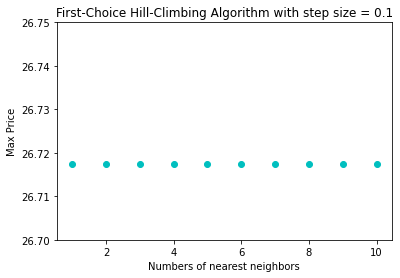

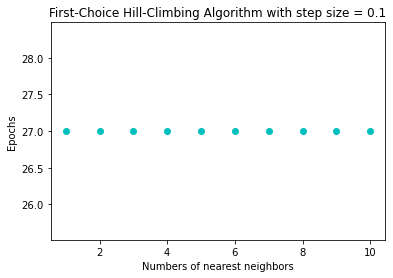

In [49]:
ep_plot =[]
price_plot =[]

for nn in np.arange(1,11,1):
    for init_val in random_init:
        max_price = 0
        ep = None
        # Choose Method
        ep,debt,price,_ = HC_FC(init_val,step=0.1,num_n=nn)
        #_,__,price,___ = HC_stochastic(init_val,step=0.1)
        #_,__,price,___ = HC_FC(init_val,step=0.1)

        if price > max_price:
            max_price = price
            #max_debt = debt
            max_ep = ep
    #print("step=" + str(step)+" Complete")
    ep_plot.append(max_ep)
    price_plot.append(max_price)

    
plt.title("First-Choice Hill-Climbing Algorithm with step size = 0.1")
plt.ylim(26.70,26.75)
plt.xlabel("Numbers of nearest neighbors")
plt.ylabel("Max Price")
plt.plot(np.arange(1,11,1),price_plot,'co')
plt.savefig("NN_FCHC_price.jpg",dpi=300)
plt.show()


plt.title("First-Choice Hill-Climbing Algorithm with step size = 0.1")
plt.xlabel("Numbers of nearest neighbors")
plt.ylabel("Epochs")
plt.plot(np.arange(1,11,1),ep_plot,'co')
plt.savefig("NN_FCHC_epochs.jpg",dpi=300)
plt.show()

In [60]:
np.unique(price_plot)

array([26.71736774, 26.71737305, 26.71737856, 26.71739679, 26.71739679,
       26.71739701, 26.71740075, 26.71740788, 26.71740807, 26.71741123,
       26.71741395, 26.71741675, 26.71741675, 26.71741898, 26.71741898,
       26.7174211 , 26.71742454, 26.71742454, 26.71742464, 26.71742464,
       26.71742587, 26.71742699, 26.71742699, 26.71742773, 26.71742773,
       26.71742827, 26.71742827, 26.71742854, 26.71742854, 26.71742854,
       26.71742854, 26.71742855])